In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [63]:
file_path = 'C:\\Users\\g_nag\\Downloads\\Dados Históricos - Ibovespa (1).csv'
df_ibovespa = pd.read_csv(file_path)

def convert_volume(volume_str):
    if isinstance(volume_str, str):
        if 'M' in volume_str:
            return float(volume_str.replace('M', '').replace(',', '.')) * 1_000_000
        elif 'K' in volume_str:
            return float(volume_str.replace('K', '').replace(',', '.')) * 1_000
        return float(volume_str.replace(',', '.'))
    return volume_str

In [64]:
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa['Data'], format='%d.%m.%Y')
df_ibovespa['Vol.'] = df_ibovespa['Vol.'].apply(convert_volume)
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

## Análise exploratória

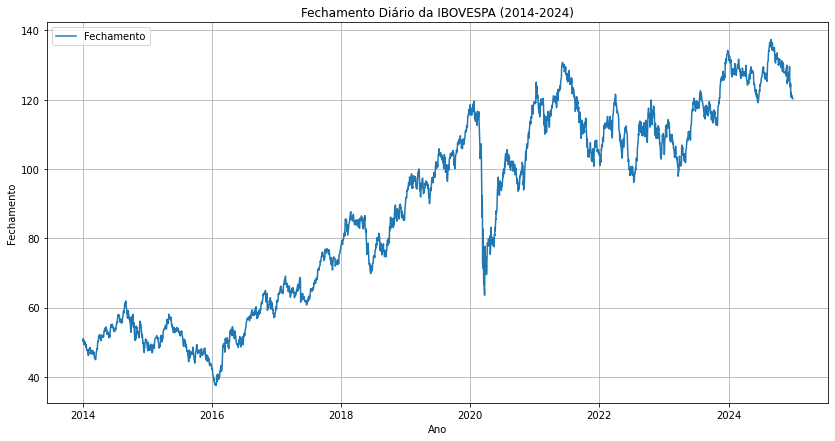

In [36]:
closing_prices = df_ibovespa.set_index('Data')['Último']
plt.figure(figsize=(14, 7))
sns.lineplot(closing_prices, label='Fechamento')
plt.title('Fechamento Diário da IBOVESPA (2014-2024)')
plt.xlabel('Ano')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)
plt.show()

### Distribuição das variáveis

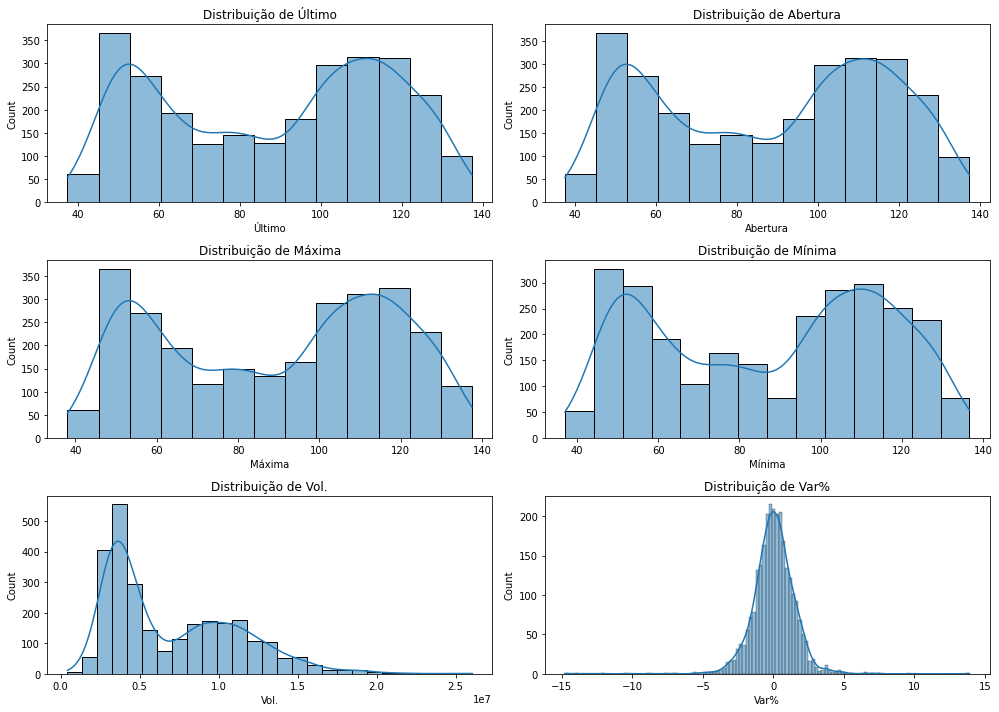

In [8]:
plt.figure(figsize=(14, 10))
for i, column in enumerate(df_ibovespa.columns[1:], 1):  # Skip 'Data' column
    plt.subplot(3, 2, i)
    sns.histplot(df_ibovespa[column], kde=True)
    plt.title(f'Distribuição de {column}')
plt.tight_layout()

### Matriz de correlação

Text(0.5, 1.0, 'Matriz de correlação')

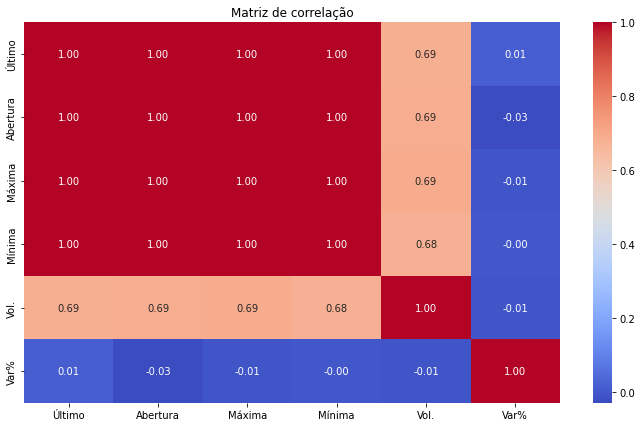

In [23]:
correlation_matrix = df_ibovespa.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlação')

### Análise temporal

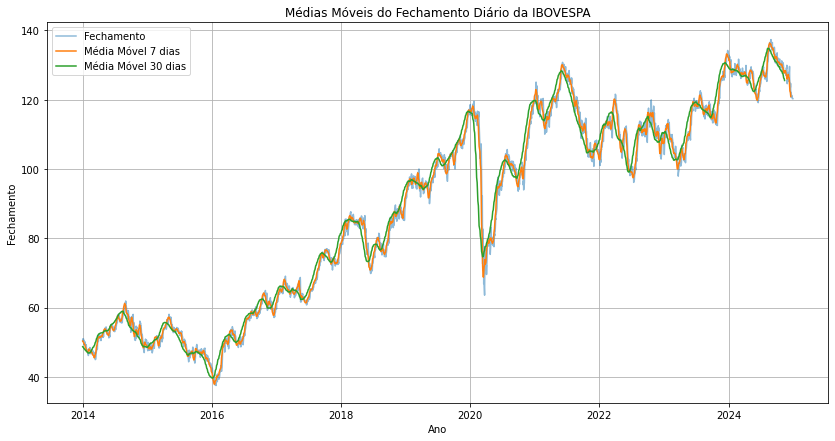

In [40]:
def plot_moving_averages(df):
    closing_prices = df.set_index('Data')['Último']
    ma_7 = closing_prices.rolling(window=7).mean()
    ma_30 = closing_prices.rolling(window=30).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(closing_prices, label='Fechamento', alpha=0.5)
    plt.plot(ma_7, label='Média Móvel 7 dias')
    plt.plot(ma_30, label='Média Móvel 30 dias')
    plt.title('Médias Móveis do Fechamento Diário da IBOVESPA')
    plt.xlabel('Ano')
    plt.ylabel('Fechamento')
    plt.legend()
    plt.grid(True)
    plt.savefig('ibovespa_medias_moveis.png')

plot_moving_averages(df_ibovespa)

### Decomposição da série temporal

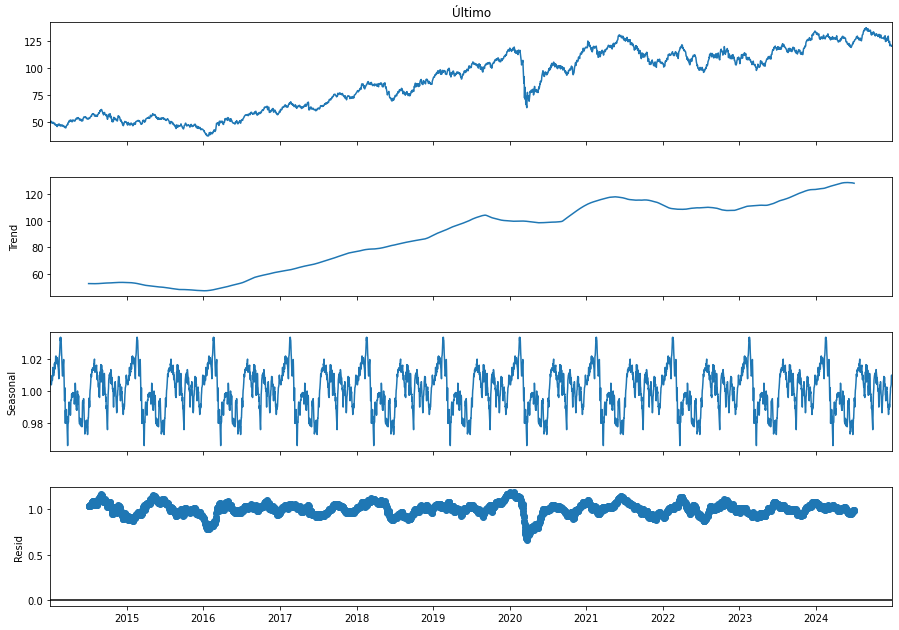

In [43]:
daily_data = df_ibovespa.set_index('Data')['Último'].resample('D').mean().interpolate(method='time')
result = seasonal_decompose(daily_data, model='multiplicative', period=365)
fig = result.plot()
fig.set_size_inches(14, 10)

### Test ADF

In [44]:
# ADF test function
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {'ADF_Statistic': result[0], 'p-value': result[1], 'Critical_Values': result[4]}

daily_adf_result = adf_test(daily_data)
print(f"ADF_Statistic: {daily_adf_result['ADF_Statistic']}")
print(f"p-value: {daily_adf_result['p-value']}")

print('Critical Values:')
for key, value in daily_adf_result['Critical_Values'].items():
    print('\t%s: %.3f' % (key, value))

ADF_Statistic: -1.4447455372713434
p-value: 0.5606466715296446
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [66]:
differenced_data = daily_data.diff().dropna()
differenced_adf_result = adf_test(differenced_data)

In [46]:
print(f"ADF_Statistic: {differenced_adf_result['ADF_Statistic']}")
print(f"p-value: {differenced_adf_result['p-value']}")

print('Critical Values:')
for key, value in differenced_adf_result['Critical_Values'].items():
    print('\t%s: %.3f' % (key, value))

ADF_Statistic: -13.831187405458527
p-value: 7.587161234013877e-26
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


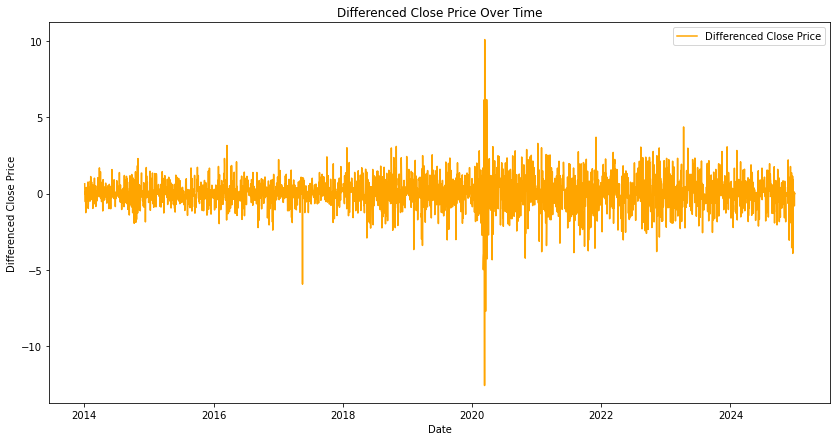

In [54]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(differenced_data.index, differenced_data, label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

Quando construimos um modelo ARIMA, temos que considerar os termos p , d e q que entram em nosso modelo ARIMA. 

O primeiro parâmetro, p , é o número de observações defasadas. Ao considerar p , determinamos efetivamente o quão longe no tempo voltamos ao tentar prever a observação atual. Fazemos isso observando as autocorrelações de nossa série temporal, que são as correlações em nossa série em defasagens de tempo anteriores. 

O segundo parâmetro, d, refere-se à ordem de diferenciação, sobre a qual falamos. Novamente, diferenciação significa simplesmente encontrar as diferenças entre intervalos de tempo consecutivos. É uma maneira de tornar nossos dados estacionários, o que significa remover as tendências e quaisquer mudanças na variância ao longo do tempo. d indica a diferenciação em qual ordem você obtém um processo estacionário.

O terceiro parâmetro q se refere à ordem da parte da média móvel (MA) do modelo. Ele representa o número de erros de previsão defasados ​​incluídos no modelo. Diferentemente de uma média móvel simples, que suaviza os dados, a média móvel no ARIMA captura a relação entre uma observação e os erros residuais de um modelo de média móvel aplicado a observações defasadas.

Usamos ferramentas como ACF (Função de Autocorrelação) e PACF (Função de Autocorrelação Parcial) para determinar os valores de p , d e q . O número de lags onde ACF corta é q , e onde PACF corta é p . 

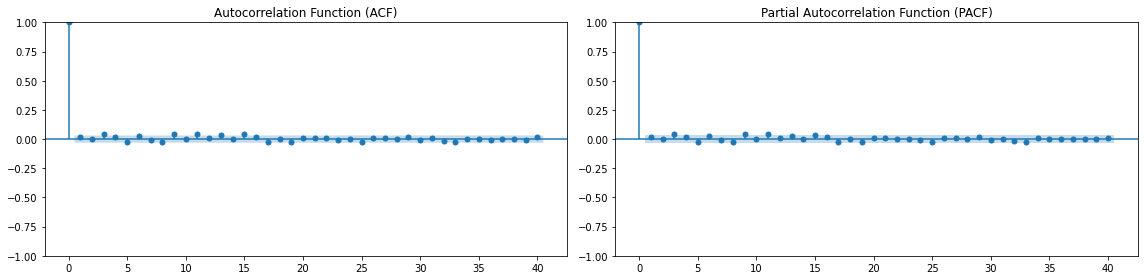

In [55]:

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(differenced_data, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(differenced_data, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Com base nesses gráficos, podemos ver que o ACF corta a linha pontilhada azul na lag 1, enquanto o PACF corta a linha pontilhada azul na lag 1. Isso sugere que um modelo ARIMA(1,1,1) pode ser adequado para a série temporal já que fizemos 1 diferenciação.

### Modelagem do ARIMA

In [165]:
# Modelagem com ARIMA
closing_prices = df_ibovespa.set_index('Data')['Último'].sort_index()
train_data = closing_prices[:'2023-12-31']
test_periods = pd.date_range('2024-01-01', periods=365, freq='B')

model_arima = ARIMA(train_data, order=(1,1,1))
model_fit = model_arima.fit()

forecast_arima = model_fit.get_forecast(steps=len(test_periods))
forecast_values = forecast_arima.predicted_mean
forecast_values_lower = forecast_arima.conf_int(alpha=0.05).iloc[:, 0]
forecast_values_upper = forecast_arima.conf_int(alpha=0.05).iloc[:, 1]

df_forecast = pd.DataFrame({
    'Data': test_periods,
    'Previsão': forecast_values,
    'Intervalo Inferior': forecast_values_lower,
    'Intervalo Superior': forecast_values_upper
})


C:\Users\g_nag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\g_nag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\g_nag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\g_nag\AppData\Local\Packages\Pytho

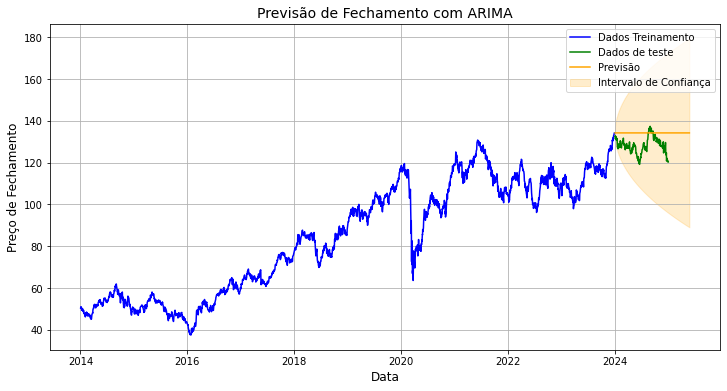

In [166]:
# Plotando os resultados
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(train_data.index, train_data, label='Dados Treinamento', color='blue')
plt.plot(closing_prices['2023-12-31':].index, closing_prices['2023-12-31':], label='Dados de teste', color='green')
# Previsões com intervalos de confiança
plt.plot(df_forecast['Data'], df_forecast['Previsão'], label='Previsão', color='orange')
plt.fill_between(
    df_forecast['Data'], 
    df_forecast['Intervalo Inferior'], 
    df_forecast['Intervalo Superior'], 
    color='orange', alpha=0.2, label='Intervalo de Confiança'
)

# Adicionando rótulos e título
plt.title('Previsão de Fechamento com ARIMA', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço de Fechamento', fontsize=12)
plt.legend()
plt.grid()

In [167]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 8324.310138060922
BIC: 8341.75212508593


In [180]:
forecast_ar = forecast_values[:len(closing_prices['2023-12-31':])]
test_close = closing_prices['2023-12-31':]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast_ar))
print(f"RMSE: {rmse:.4f}")

RMSE: 7.0736


### Modelagem com prophet

In [124]:
model_df = df_ibovespa[['Data', 'Último']].rename(columns={'Data': 'ds', 'Último': 'y'})

In [126]:
m = Prophet()
m.fit(model_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

20:40:57 - cmdstanpy - INFO - Chain [1] start processing
20:41:00 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
3087,2025-12-26,144.417485,125.326792,162.065893
3088,2025-12-27,145.094880,125.103693,163.367714
3089,2025-12-28,145.266199,125.636580,162.372109
3090,2025-12-29,144.865077,125.093022,161.661787
3091,2025-12-30,145.150933,124.670348,162.328089


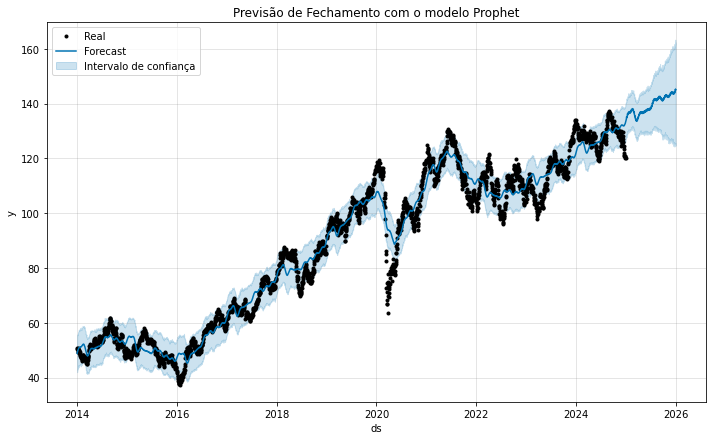

In [150]:
fig = m.plot(forecast)
ax = fig.gca()
ax.set_title('Previsão de Fechamento com o modelo Prophet')
ax.legend(['Real', 'Forecast', 'Intervalo de confiança'], loc='upper left')
plt.show()

In [143]:
fig2 = plot_plotly(m, forecast)
fig2.update_layout(title='Previsão de Fechamento com o modelo Prophet')
fig2.update_xaxes(title_text='Data')
fig2.update_yaxes(title_text='Preço de Fechamento')
fig2.show()

In [129]:
plot_components_plotly(m, forecast)

In [131]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/17 [00:00<?, ?it/s]

20:53:26 - cmdstanpy - INFO - Chain [1] start processing
20:53:26 - cmdstanpy - INFO - Chain [1] done processing
20:53:26 - cmdstanpy - INFO - Chain [1] start processing
20:53:27 - cmdstanpy - INFO - Chain [1] done processing
20:53:27 - cmdstanpy - INFO - Chain [1] start processing
20:53:27 - cmdstanpy - INFO - Chain [1] done processing
20:53:27 - cmdstanpy - INFO - Chain [1] start processing
20:53:28 - cmdstanpy - INFO - Chain [1] done processing
20:53:28 - cmdstanpy - INFO - Chain [1] start processing
20:53:28 - cmdstanpy - INFO - Chain [1] done processing
20:53:28 - cmdstanpy - INFO - Chain [1] start processing
20:53:29 - cmdstanpy - INFO - Chain [1] done processing
20:53:29 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1]

In [132]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,67.196240,8.197331,6.437001,0.066832,0.054870,0.068016,0.384996
1,37 days,67.274062,8.202077,6.471858,0.067280,0.055044,0.068436,0.379256
2,38 days,67.050895,8.188461,6.483300,0.067543,0.055385,0.068702,0.378266
3,39 days,65.895052,8.117577,6.443388,0.067534,0.055385,0.068760,0.380048
4,40 days,64.966843,8.060201,6.428958,0.067826,0.055468,0.069145,0.377276


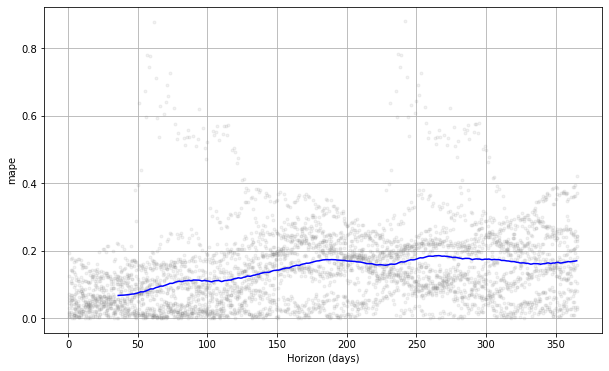

In [133]:
fig = plot_cross_validation_metric(df_cv, metric='mape')